# Shap analysis of principal components
# Workflow: execute after analysis 07_shap_execution

In [2]:
import shap
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from util import colors_default, centimeter_to_inch

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Loading data

In [3]:
K = [5]

df_pca = pd.read_csv('data/df_pca_risk_factors.csv', index_col=0)

X = pd.read_csv('data/x_shap_values_risk_factors.csv', index_col=0)

df_base = pd.read_csv('data/df_labeled_risk_factors.csv', index_col=0)

shap_values_k = {}
df_k = {}

for k in K:
    filename = 'data/shap_values_risk_factors_k_' + str(k) + '.npy'
    shap_values_temp = np.load(filename)
    shap_values = []
    for i in range(len(shap_values_temp)):
        shap_values.append(shap_values_temp[i])
    shap_values_k[k] = shap_values

    filename = 'data/df_pca_risk_factors_shap_k_' + str(k) + '.csv'
    df = pd.read_csv(filename, index_col=0)
    df_k[k] = pd.merge(df_base, df, how='left', left_index=True, right_index=True)

atributos = ['PC 1', 'PC 2']

## Labeling classes

In [4]:
y_label = {}

y_label[5] = [None, None, None, None, None]
k5 = df_base.groupby(['k5', 'k5_label']).count()[[]].reset_index().values
for i in range(len(k5)):
    y_label[5][k5[i][0]] = k5[i][1]

y_label

{5: ['High SV',
  'Rural with low SV',
  'Very low SV',
  'Very high SV',
  'Intermediate SV']}

## SHAP por k

In [6]:
colors = [colors_default['muito_maior'], colors_default['muito_menor'], colors_default['medio'], colors_default['maior'], colors_default['menor']]
colormap = ListedColormap(colors)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f0d23135dc0>
Traceback (most recent call last):
  File "/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/helder/anaconda3/envs/base-r/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


k:  5


X has feature names, but GaussianMixture was fitted without feature names
Using 556 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


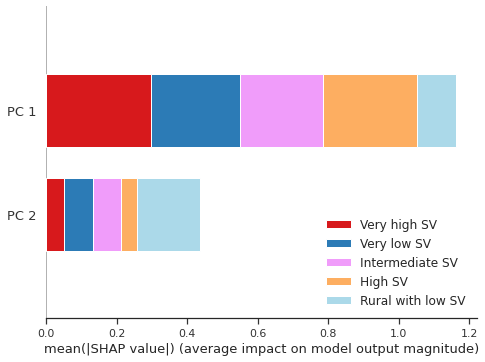

In [7]:
for k in K:
    print('k: ', k)
    filename = 'data/em_spherical_weights_risk_factors_k_' + str(k) + '.npy'
    em_spherical_weights = np.load(filename)

    filename = 'data/em_spherical_means_risk_factors_k_' + str(k) + '.npy'
    em_spherical_means = np.load(filename)

    filename = 'data/em_spherical_precisions_risk_factors_k_' + str(k) + '.npy'
    em_spherical_precisions = np.load(filename)

    model = GaussianMixture(k, n_init=1, covariance_type='spherical', weights_init=em_spherical_weights, means_init=em_spherical_means, precisions_init=em_spherical_precisions)
    model.fit(df_pca)
    shap_values = shap_values_k[k]
    shap.initjs()
    explainer = shap.KernelExplainer(model.predict_proba, X, keep_index = True)

    sns.set(font_scale=1.1)
    sns.set_style("ticks")
    shap.summary_plot(shap_values, X, title='k:  '+str(k), show=False, feature_names=atributos, class_names=y_label[k], plot_size=(centimeter_to_inch(17.4),centimeter_to_inch(13.05)), color=colormap)

    plt.legend(loc='lower right', frameon=False)
    plt.savefig('images/shap_clusters.pdf', bbox_inches="tight")
    plt.savefig('images/shap_clusters.eps', bbox_inches="tight")
    plt.show()

## Analysis by classes

k:  5
High SV


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


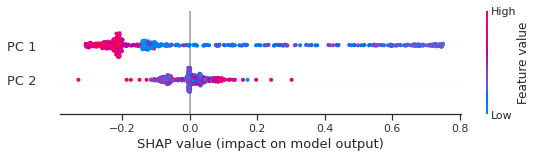

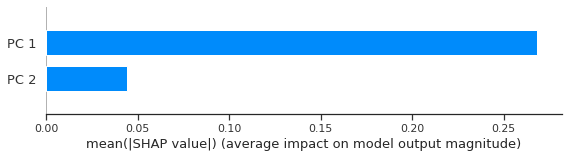

Rural with low SV


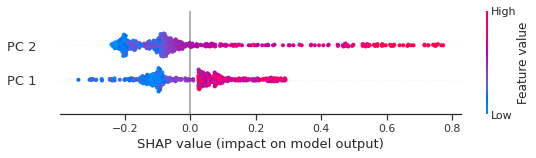

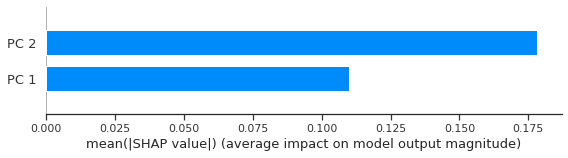

Very low SV


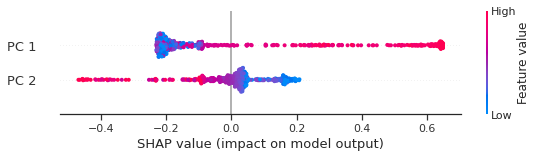

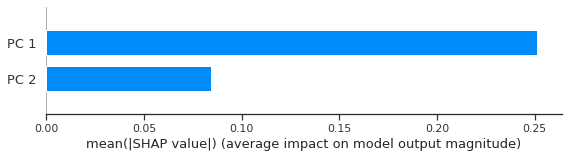

Very high SV


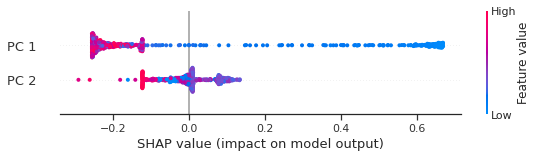

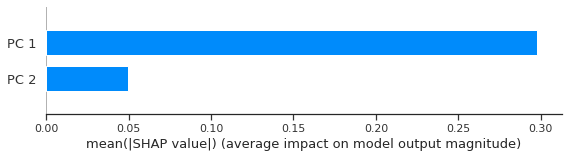

Intermediate SV


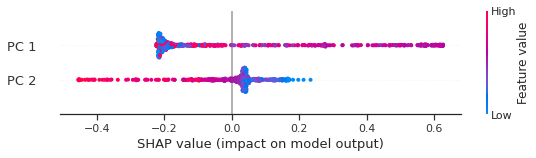

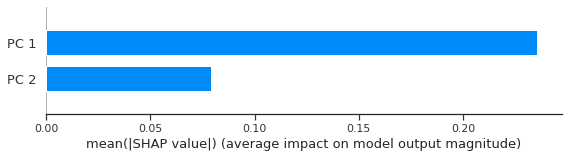

In [8]:
df_X_original_values = df_base.filter(X.index, axis=0)
df_X_original_values = X

for k in K:
    print('k: ', k)

    shap_values = shap_values_k[k]

    for classe in range(k):
        print(y_label[k][classe])

        shap.summary_plot(shap_values[classe], df_X_original_values, title=str(classe), show=False, feature_names=atributos)
        plt.show()

        shap.summary_plot(shap_values[classe], df_X_original_values, title=str(classe), show=False, feature_names=atributos, plot_type='bar')
        plt.show()

In [9]:
classe = 0
shap.force_plot(explainer.expected_value[classe], shap_values[classe], df_X_original_values)

In [10]:
classe = 1
sample = 2
shap.force_plot(explainer.expected_value[classe], shap_values[classe][sample], X.iloc[sample])

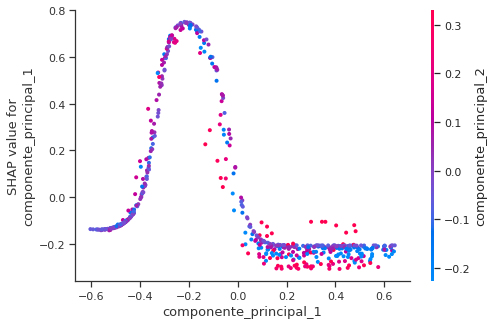

In [11]:
shap.dependence_plot("componente_principal_1",
                     shap_values[0],
                     df_X_original_values,
                     interaction_index='componente_principal_2', show=False)